In [7]:
#Imports
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler

In [8]:
import matplotlib.pyplot as plt
import seaborn as sns

In [9]:
#Load Data & Train Test Split
train_data = pd.read_csv('./train.csv')
test_data = pd.read_csv('./test.csv')

In [10]:
train_data.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [11]:
train_data.isnull().sum()

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

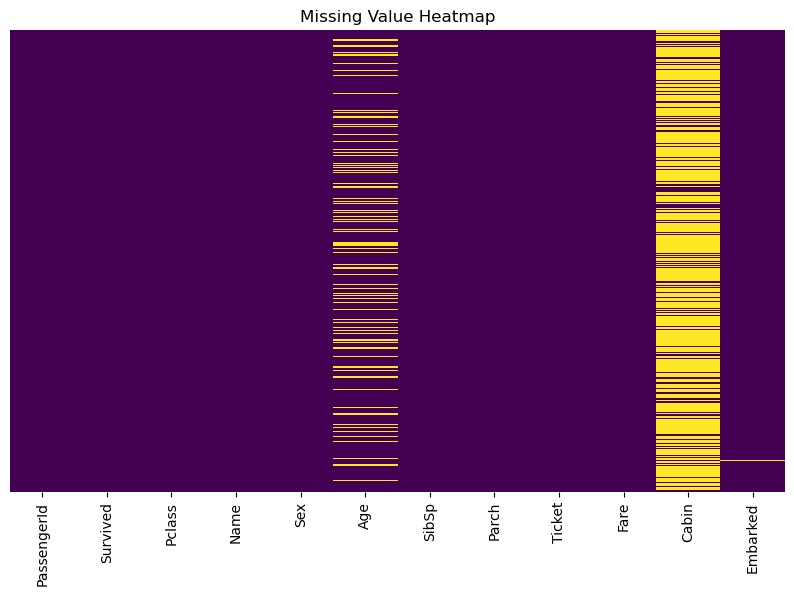

In [12]:
plt.figure(figsize=(10, 6))
sns.heatmap(train_data.isnull(), yticklabels=False, cbar=False, cmap='viridis')
plt.title('Missing Value Heatmap')
plt.show()

In [13]:
train_data.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


In [14]:
for column in train_data.select_dtypes(include=['object']).columns:
    print(f"\nUnique values in {column}:")
    print(train_data[column].value_counts())


Unique values in Name:
Name
Braund, Mr. Owen Harris                     1
Boulos, Mr. Hanna                           1
Frolicher-Stehli, Mr. Maxmillian            1
Gilinski, Mr. Eliezer                       1
Murdlin, Mr. Joseph                         1
                                           ..
Kelly, Miss. Anna Katherine "Annie Kate"    1
McCoy, Mr. Bernard                          1
Johnson, Mr. William Cahoone Jr             1
Keane, Miss. Nora A                         1
Dooley, Mr. Patrick                         1
Name: count, Length: 891, dtype: int64

Unique values in Sex:
Sex
male      577
female    314
Name: count, dtype: int64

Unique values in Ticket:
Ticket
347082      7
CA. 2343    7
1601        7
3101295     6
CA 2144     6
           ..
9234        1
19988       1
2693        1
PC 17612    1
370376      1
Name: count, Length: 681, dtype: int64

Unique values in Cabin:
Cabin
B96 B98        4
G6             4
C23 C25 C27    4
C22 C26        3
F33            3
   

In [15]:
def extract_title(name):
    return name.split(',')[1].split('.')[0].strip()

def is_married(title):
    married_titles = ['Mrs', 'Mme', 'Lady']
    return 1 if title in married_titles else 0

def extract_deck(cabin):
    if pd.isna(cabin):
        return 'Unknown'
    deck = cabin[0].upper()
    if deck in 'ABCDEFG':
        return deck
    return 'Other'

def bin_age(age):
    if pd.isnull(age):
        return 'Unknown'
    elif age <= 12:
        return 'Child'
    elif age <= 18:
        return 'Teen'
    elif age <= 35:
        return 'Young Adult'
    elif age <= 60:
        return 'Adult'
    else:
        return 'Senior'

def bin_fare(fare):
    if pd.isnull(fare):
        return 'Unknown'
    elif fare <= 7.91:
        return 'Low'
    elif fare <= 14.454:
        return 'Medium-Low'
    elif fare <= 31:
        return 'Medium-High'
    else:
        return 'High'
    
def is_parent(row):
    return 1 if row['Parch'] > 0 and row['Age'] > 18 else 0

def bin_family_size(size):
    if size == 1:
        return 'Alone'
    elif size <= 3:
        return 'Small'
    elif size <= 6:
        return 'Medium'
    else:
        return 'Large'

def add_family_survival_rate(df, is_train=True, family_rates=None):
    # Create a family identifier
    df['FamilyID'] = df['LastName'] + df['Fare'].astype(str)
    
    if is_train:
        # Calculate family size
        family_sizes = df.groupby('FamilyID')['PassengerId'].transform('count')
        
        # Calculate number of survivors in each family
        family_survivors = df.groupby('FamilyID')['Survived'].transform('sum')
        
        # Calculate family survival rate
        df['FamilySurvivalRate'] = family_survivors / family_sizes
        
        # For passengers traveling alone, use the mean survival rate
        mean_survival_rate = df['Survived'].mean()
        df.loc[family_sizes == 1, 'FamilySurvivalRate'] = mean_survival_rate
        
        # Store family rates for later use with test data
        family_rates = df.groupby('FamilyID')['FamilySurvivalRate'].first()
    else:
        # For test data, use the family rates from the training data
        df['FamilySurvivalRate'] = df['FamilyID'].map(family_rates)
        # For families not in the training data, use the mean survival rate
        df['FamilySurvivalRate'].fillna(family_rates.mean(), inplace=True)
    
    # Drop the temporary FamilyID column
    df = df.drop('FamilyID', axis=1)
    
    return df, family_rates

def extract_lastname(name):
    return name.split(',')[0].strip()

def add_interactions(df):
    df['Pclass_Sex'] = df['Pclass'].astype(str) + '_' + df['Sex']
    df['Age_Pclass'] = df['AgeBin'] + '_' + df['Pclass'].astype(str)
    df['Sex_Deck'] = df['Sex'] + '_' + df['Deck']
    df['Pclass_Embarked'] = df['Pclass'].astype(str) + '_' + df['Embarked']
    df['Sex_FamilySize'] = df['Sex'] + '_' + df['FamilySizeBin']
    df['Age_Sex'] = df['AgeBin'] + '_' + df['Sex']
    return df
    
def preprocess_data(df, is_train=True, family_rates=None):
# Extract last name from name
    df['LastName'] = df['Name'].apply(extract_lastname)

    # Extract title from name
    df['Title'] = df['Name'].apply(extract_title)
    
    # Create IsMarried feature
    df['IsMarried'] = df['Title'].apply(is_married)

    # Create FamilySize feature
    df['FamilySize'] = df['SibSp'] + df['Parch'] + 1
    
    # Create IsParent feature
    df['IsParent'] = df.apply(is_parent, axis=1)

    # Create FarePerPerson feature
    df['FarePerPerson'] = df['Fare'] / df['FamilySize']
    
    # Create HasCabin feature
    df['HasCabin'] = (~df['Cabin'].isna()).astype(int)
    
    # Create Deck feature
    df['Deck'] = df['Cabin'].apply(extract_deck)

    # Create IsTravellingAlone feature
    df['IsTravellingAlone'] = (df['FamilySize'] == 1).astype(int)
    
    # Bin age
    df['AgeBin'] = df['Age'].apply(bin_age)

    # Bin FamilySize
    df['FamilySizeBin'] = df['FamilySize'].apply(bin_family_size)
    
    # Bin fare
    df['FareBin'] = df['Fare'].apply(bin_fare)

    # Add family survival rate
    df, family_rates = add_family_survival_rate(df, is_train, family_rates)
    
    return df, family_rates

In [16]:
# Data Cleaning
train_data, family_rates = preprocess_data(train_data, is_train=True)
test_data, _ = preprocess_data(test_data, is_train=False, family_rates=family_rates)

train_data = add_interactions(train_data)
test_data = add_interactions(test_data) 

/var/folders/ss/4jz_k5ws6hv7rqvyffmpszr00000gn/T/ipykernel_96564/3666933735.py:79: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['FamilySurvivalRate'].fillna(family_rates.mean(), inplace=True)


In [17]:
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import LabelEncoder
import numpy as np

# First, let's check what features are available
print("Available features:", train_data.columns.tolist())

# Select features to use for prediction (adjust this based on available features)
features_for_age = ['Pclass', 'Sex', 'Embarked', 'SibSp', 'Parch', 'Fare']  # Add other available features here

# Create a copy of the data with only the selected features
age_data = train_data[features_for_age + ['Age']].copy()

# Encode categorical variables
le = LabelEncoder()
for col in features_for_age:
    if age_data[col].dtype == 'object':
        age_data[col] = le.fit_transform(age_data[col].astype(str))

# Split into sets with known and unknown Age
known_age = age_data[age_data['Age'].notna()]
unknown_age = age_data[age_data['Age'].isna()]

# Prepare the data
X_train = known_age[features_for_age]
y_train = known_age['Age']

# Split the known data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

# Create DMatrix for XGBoost
dtrain = xgb.DMatrix(X_train, label=y_train)
dval = xgb.DMatrix(X_val, label=y_val)

# Set XGBoost parameters
params = {
    'objective': 'reg:squarederror',
    'eval_metric': 'rmse',
    'max_depth': 6,
    'learning_rate': 0.1,
    'n_estimators': 100
}

# Train the model
model = xgb.train(
    params,
    dtrain,
    num_boost_round=1000,
    evals=[(dtrain, 'train'), (dval, 'val')],
    early_stopping_rounds=20,
    verbose_eval=50
)

# Predict missing ages
dpredict = xgb.DMatrix(unknown_age[features_for_age])
predicted_ages = model.predict(dpredict)

# Fill in the missing ages in the original dataframe
train_data.loc[train_data['Age'].isna(), 'Age'] = predicted_ages

# Print RMSE on validation set
y_pred = model.predict(dval)
rmse = np.sqrt(mean_squared_error(y_val, y_pred))
print(f"RMSE on validation set: {rmse}")

# Feature importance
importance = model.get_score(importance_type='gain')
sorted_importance = sorted(importance.items(), key=lambda x: x[1], reverse=True)
print("\nFeature Importance:")
for feature, importance in sorted_importance:
    print(f"{feature}: {importance}")

# Impute Embarked
train_data['Embarked'].fillna(train_data['Embarked'].mode()[0], inplace=True)

Available features: ['PassengerId', 'Survived', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp', 'Parch', 'Ticket', 'Fare', 'Cabin', 'Embarked', 'LastName', 'Title', 'IsMarried', 'FamilySize', 'IsParent', 'FarePerPerson', 'HasCabin', 'Deck', 'IsTravellingAlone', 'AgeBin', 'FamilySizeBin', 'FareBin', 'FamilySurvivalRate', 'Pclass_Sex', 'Age_Pclass', 'Sex_Deck', 'Pclass_Embarked', 'Sex_FamilySize', 'Age_Sex']
[0]	train-rmse:14.11314	val-rmse:13.10689


/opt/miniconda3/envs/titanic_env/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [12:59:24] WARNING: /var/folders/k1/30mswbxs7r1g6zwn8y4fyt500000gp/T/abs_d9k8pmaj4_/croot/xgboost-split_1724073758172/work/src/learner.cc:740: 
Parameters: { "n_estimators" } are not used.

  warnings.warn(smsg, UserWarning)


[37]	train-rmse:9.28329	val-rmse:10.92919
RMSE on validation set: 10.92919336358058

Feature Importance:
Pclass: 1189.134033203125
Parch: 565.8772583007812
SibSp: 219.8992919921875
Fare: 144.88233947753906
Embarked: 124.15361785888672
Sex: 103.8066635131836


/var/folders/ss/4jz_k5ws6hv7rqvyffmpszr00000gn/T/ipykernel_96564/2122347231.py:76: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  train_data['Embarked'].fillna(train_data['Embarked'].mode()[0], inplace=True)


In [18]:
#dropping name as that is useless
#dropping ticket number as also useless unless we can parse in a useful way
#cabin is literally missing all of it lmfaoo, just get rid of it
train_data = train_data.drop(columns=['Name', 'Ticket', 'Cabin'])
test_data = test_data.drop(columns=['Name', 'Ticket', 'Cabin'])

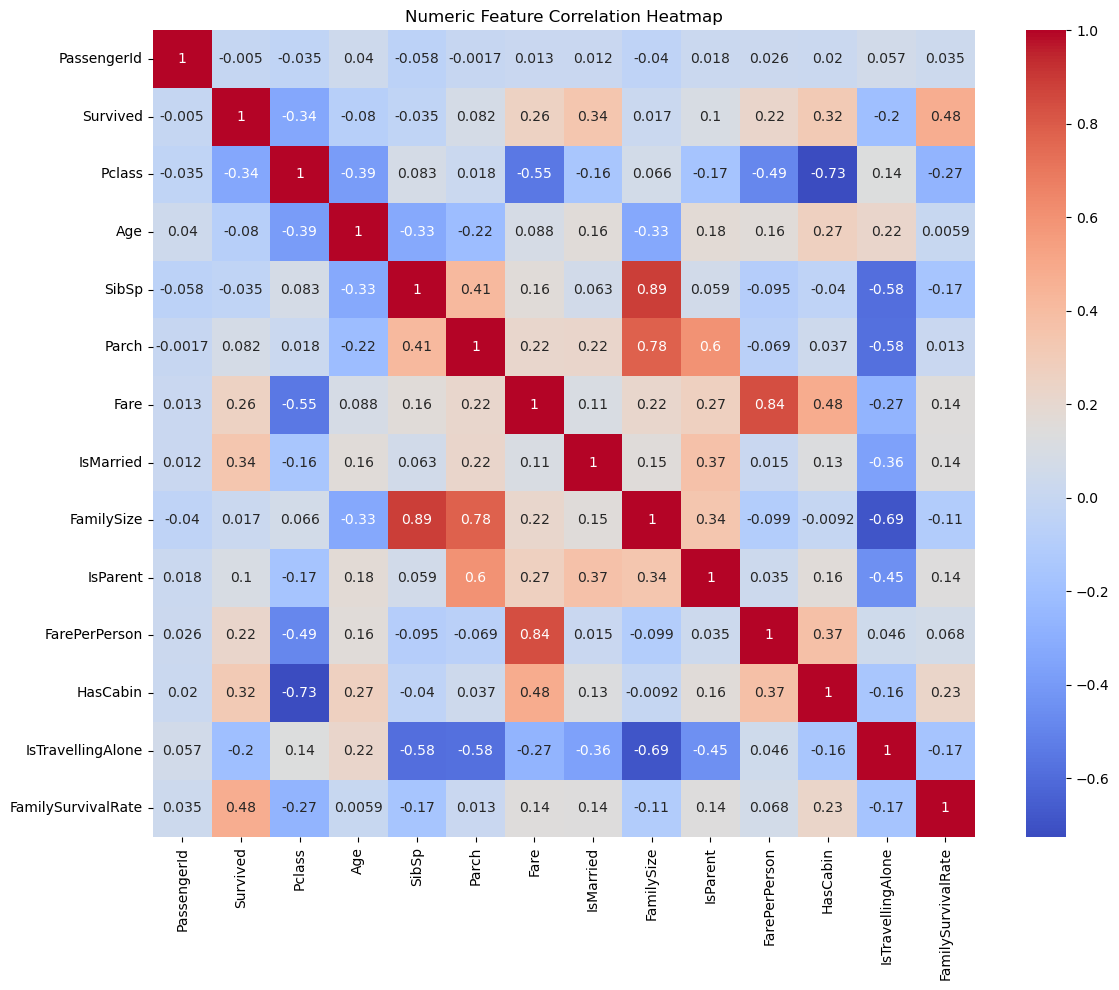

Highly correlated numeric features: [('SibSp', 'FamilySize'), ('Fare', 'FarePerPerson')]


In [19]:
import seaborn as sns
import matplotlib.pyplot as plt

numeric_columns = train_data.select_dtypes(include=['int64', 'float64']).columns
categorical_columns = train_data.select_dtypes(exclude=['int64', 'float64']).columns
# Compute the correlation matrix for numeric columns
corr_matrix = train_data[numeric_columns].corr()

# Plot a heatmap
plt.figure(figsize=(12, 10))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm')
plt.title('Numeric Feature Correlation Heatmap')
plt.tight_layout()
plt.show()

# Find highly correlated features
high_corr_features = np.where(np.abs(corr_matrix) > 0.8)
high_corr_features = [(corr_matrix.index[x], corr_matrix.columns[y]) for x, y in zip(*high_corr_features) if x != y and x < y]
print("Highly correlated numeric features:", high_corr_features)

In [20]:
print(train_data[categorical_columns].dtypes)
print(train_data[categorical_columns].head())

Sex                object
Embarked           object
LastName           object
Title              object
Deck               object
AgeBin             object
FamilySizeBin      object
FareBin            object
Pclass_Sex         object
Age_Pclass         object
Sex_Deck           object
Pclass_Embarked    object
Sex_FamilySize     object
Age_Sex            object
dtype: object
      Sex Embarked   LastName Title     Deck       AgeBin FamilySizeBin  \
0    male        S     Braund    Mr  Unknown  Young Adult         Small   
1  female        C    Cumings   Mrs        C        Adult         Small   
2  female        S  Heikkinen  Miss  Unknown  Young Adult         Alone   
3  female        S   Futrelle   Mrs        C  Young Adult         Small   
4    male        S      Allen    Mr  Unknown  Young Adult         Alone   

      FareBin Pclass_Sex     Age_Pclass        Sex_Deck Pclass_Embarked  \
0         Low     3_male  Young Adult_3    male_Unknown             3_S   
1        High   1_fem

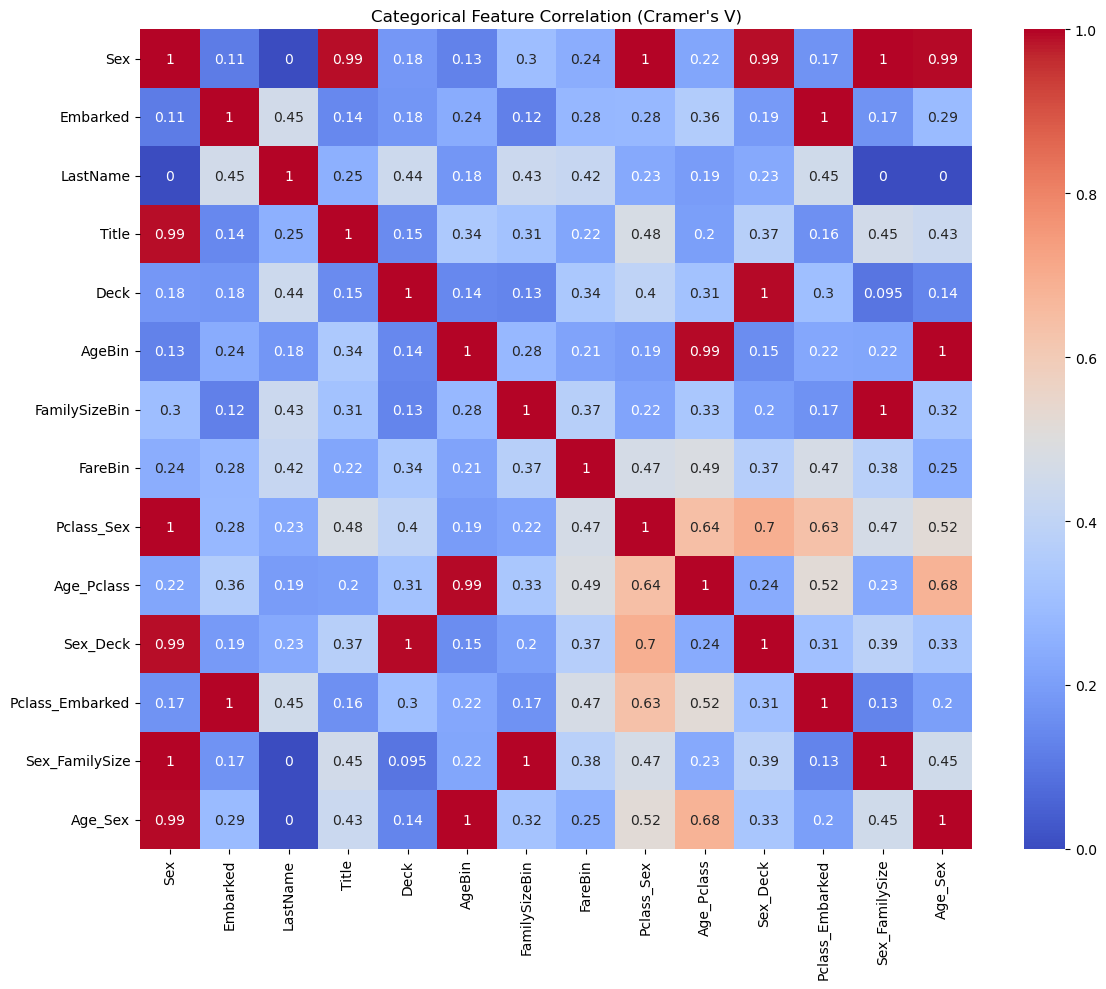

Highly correlated categorical feature pairs:
Sex and Title: 0.99
Sex and Pclass_Sex: 1.00
Sex and Sex_Deck: 0.99
Sex and Sex_FamilySize: 1.00
Sex and Age_Sex: 0.99
Embarked and Pclass_Embarked: 1.00
Title and Sex: 0.99
Deck and Sex_Deck: 1.00
AgeBin and Age_Pclass: 0.99
AgeBin and Age_Sex: 1.00
FamilySizeBin and Sex_FamilySize: 1.00
Pclass_Sex and Sex: 1.00
Age_Pclass and AgeBin: 0.99
Sex_Deck and Sex: 0.99
Sex_Deck and Deck: 1.00
Pclass_Embarked and Embarked: 1.00
Sex_FamilySize and Sex: 1.00
Sex_FamilySize and FamilySizeBin: 1.00
Age_Sex and Sex: 0.99
Age_Sex and AgeBin: 1.00


In [21]:
import numpy as np
import pandas as pd
from scipy.stats import chi2_contingency
import seaborn as sns
import matplotlib.pyplot as plt

def cramers_v(x, y):
    confusion_matrix = pd.crosstab(x, y)
    chi2 = chi2_contingency(confusion_matrix)[0]
    n = confusion_matrix.sum().sum()
    phi2 = chi2 / n
    r, k = confusion_matrix.shape
    phi2corr = max(0, phi2 - ((k-1)*(r-1))/(n-1))
    rcorr = r - ((r-1)**2)/(n-1)
    kcorr = k - ((k-1)**2)/(n-1)
    return np.sqrt(phi2corr / min((kcorr-1), (rcorr-1)))

# Exclude 'LastName' from the analysis
categorical_columns = train_data.select_dtypes(include=['object', 'category']).columns.tolist()

# Calculate Cramer's V for all pairs of categorical variables
cramer_matrix = pd.DataFrame(index=categorical_columns, columns=categorical_columns, dtype=float)
for col1 in categorical_columns:
    for col2 in categorical_columns:
        try:
            cramer_matrix.loc[col1, col2] = cramers_v(train_data[col1], train_data[col2])
        except:
            cramer_matrix.loc[col1, col2] = np.nan

# Replace any remaining non-numeric values with NaN
cramer_matrix = cramer_matrix.apply(pd.to_numeric, errors='coerce')

# Plot heatmap
plt.figure(figsize=(12, 10))
sns.heatmap(cramer_matrix, annot=True, cmap='coolwarm', vmin=0, vmax=1, mask=np.isnan(cramer_matrix))
plt.title('Categorical Feature Correlation (Cramer\'s V)')
plt.tight_layout()
plt.show()

# Print highly correlated pairs
high_corr_threshold = 0.7  # You can adjust this threshold
high_corr_pairs = []
for col1 in categorical_columns:
    for col2 in categorical_columns:
        if col1 != col2 and cramer_matrix.loc[col1, col2] > high_corr_threshold:
            high_corr_pairs.append((col1, col2, cramer_matrix.loc[col1, col2]))

print("Highly correlated categorical feature pairs:")
for pair in high_corr_pairs:
    print(f"{pair[0]} and {pair[1]}: {pair[2]:.2f}")

In [22]:
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold

features_to_drop = ['SibSp', 'Fare', 'Title', 'Pclass_Sex', 'Sex_Deck', 'Age_Pclass', 'Pclass_Embarked', 'Sex_FamilySize', 'Age_Sex' ]
train_data = train_data.drop(columns=features_to_drop)
test_data = test_data.drop(columns=features_to_drop)

x = train_data.drop('Survived', axis=1)
y = train_data['Survived']

#k fold cross validation
n_splits = 10
kf = KFold(n_splits=n_splits, shuffle=True, random_state=42)

revist the above to potentially improve accuracy

In [23]:
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

In [24]:
# Feature Encoding
numerical_columns = ['Age', 'Parch', 'IsMarried', 'IsParent', 'FamilySize' , 'IsTravellingAlone', 'FarePerPerson', 'HasCabin', 'FamilySurvivalRate']
nominal_columns = ['Sex', 'Embarked']
ordinal_columns = ['Pclass', 'AgeBin', 'FareBin', 'FamilySizeBin', 'Deck']

pclass_order = ['3', '2', '1']
age_order = ['Unknown', 'Child', 'Teen', 'Young Adult', 'Adult', 'Senior']
fare_order = ['Unknown', 'Low', 'Medium-Low', 'Medium-High', 'High']
family_size_order = ['Alone', 'Small', 'Medium', 'Large']
deck_order = ['Unknown', 'G', 'F', 'E', 'D', 'C', 'B', 'A', 'Other']

train_data['Pclass'] = train_data['Pclass'].astype(str)
test_data['Pclass'] = test_data['Pclass'].astype(str)

# Function to create pipeline for numerical columns
def numerical_pipeline():
    return Pipeline([
        ('imputer', SimpleImputer(strategy='median')),
        ('scaler', StandardScaler())
    ])

# Function to create pipeline for nominal columns
def nominal_pipeline():
    return Pipeline([
        ('imputer', SimpleImputer(strategy='constant', fill_value='Unknown')),
        ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
    ])

# Function to create pipeline for ordinal columns
def ordinal_pipeline():
    return Pipeline([
        ('imputer', SimpleImputer(strategy='constant', fill_value="Unknown")), #can mess around with this
        ('ordinal', OrdinalEncoder(categories=[pclass_order, age_order, fare_order, family_size_order, deck_order], 
                            handle_unknown='use_encoded_value', 
                            unknown_value=-1))
    ])

# Create the preprocessing steps
preprocessor = ColumnTransformer(
   transformers=[
        ('num', numerical_pipeline(), numerical_columns),
        ('nom', nominal_pipeline(), nominal_columns),
        ('ord', ordinal_pipeline(), ordinal_columns)
    ])

# Full preprocessing pipeline
full_preprocessor = Pipeline([
    ('preprocessor', preprocessor)
])

In [25]:
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import numpy as np

In [26]:
import optuna
import torch.nn as nn
import torch.optim as optim
from sklearn.metrics import accuracy_score

class TitanicNet(nn.Module):
    def __init__(self, input_size, n_units, dropout):
        super(TitanicNet, self).__init__()
        layers = []
        in_features = input_size
        for units in n_units:
            layers.append(nn.Linear(in_features, units))
            layers.append(nn.ReLU())
            layers.append(nn.Dropout(dropout))
            in_features = units
        layers.append(nn.Linear(in_features, 1))
        layers.append(nn.Sigmoid())
        self.model = nn.Sequential(*layers)

    def forward(self, x):
        return self.model(x)
        
def objective(trial):
    # Hyperparameters to tune
    lr = trial.suggest_float('lr', 1e-5, 1e-1, log=True)
    n_layers = trial.suggest_int('n_layers', 1, 5)
    n_units = [trial.suggest_int(f'n_units_l{i}', 32, 512) for i in range(n_layers)]
    dropout = trial.suggest_float('dropout', 0.0, 0.5)
    n_epochs = trial.suggest_int('n_epochs', 50, 500)

    fold_accuracies = []
    global_step = 0

    for fold, (train_idx, val_idx) in enumerate(kf.split(x)):
        #split the data
        x_train_fold, x_val_fold = x.iloc[train_idx], x.iloc[val_idx]
        y_train_fold, y_val_fold = y.iloc[train_idx], y.iloc[val_idx]

        #preprocess the data
        x_train_fold_encoded = preprocessor.fit_transform(x_train_fold)
        x_val_fold_encoded = preprocessor.transform(x_val_fold)

        #convert to pytorch tensors
        x_train_tensor = torch.FloatTensor(x_train_fold_encoded)
        y_train_tensor = torch.FloatTensor(y_train_fold.values).unsqueeze(1)
        x_val_tensor = torch.FloatTensor(x_val_fold_encoded)
        y_val_tensor = torch.FloatTensor(y_val_fold.values).unsqueeze(1)
        
        #initialize model
        input_size = x_train_tensor.shape[1]
        model = TitanicNet(input_size, n_units, dropout)
        criterion = nn.BCELoss()
        optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=1e-5)

        best_val_loss = float('inf')
        patience = 10
        epochs_without_improvement = 0

        # Training loop
        for epoch in range(n_epochs):
            model.train()
            optimizer.zero_grad()
            outputs = model(x_train_tensor)
            loss = criterion(outputs, y_train_tensor)
            loss.backward()
            optimizer.step()

            # Validation step
            model.eval()
            with torch.no_grad():
                val_outputs = model(x_val_tensor)
                val_loss = criterion(val_outputs, y_val_tensor)

            # Early stopping check
            if val_loss < best_val_loss:
                best_val_loss = val_loss
                epochs_without_improvement = 0
            else:
                epochs_without_improvement += 1

            if epochs_without_improvement >= patience:
                break

            #Optuna pruning check
            trial.report(val_loss, global_step)
            global_step += 1
            if trial.should_prune():
                raise optuna.TrialPruned()

        #validation
        model.eval()
        with torch.no_grad():
            val_outputs = model(x_val_tensor)
            val_preds =(val_outputs > 0.5).float()

            val_preds_np = val_preds.cpu().numpy().flatten()
            y_val_np = y_val_tensor.cpu().numpy().flatten()

            accuracy = accuracy_score(y_val_np, val_preds_np)

        fold_accuracies.append(accuracy)

    return np.mean(fold_accuracies)

# Create and run the study
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=100)  # Adjust n_trials as needed

# Print results
print("Best trial:")
trial = study.best_trial
print("  Value: ", trial.value)
print("  Params: ")
for key, value in trial.params.items():
    print("    {}: {}".format(key, value))

/opt/miniconda3/envs/titanic_env/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
[I 2024-10-04 12:59:29,527] A new study created in memory with name: no-name-0de40223-36ce-48fb-b7b8-1872994fce11
[I 2024-10-04 12:59:35,415] Trial 0 finished with value: 0.8608239700374531 and parameters: {'lr': 0.025645753777463934, 'n_layers': 4, 'n_units_l0': 110, 'n_units_l1': 300, 'n_units_l2': 329, 'n_units_l3': 277, 'dropout': 0.34197636492400424, 'n_epochs': 73}. Best is trial 0 with value: 0.8608239700374531.
[I 2024-10-04 12:59:39,140] Trial 1 finished with value: 0.866441947565543 and parameters: {'lr': 0.0038018193647394935, 'n_layers': 3, 'n_units_l0': 317, 'n_units_l1': 378, 'n_units_l2': 175, 'dropout': 0.33905202489512765, 'n_epochs': 77}. Best is trial 1 with value: 0.866441947565543.
[I 2024-10-04 12:59:4

Best trial:
  Value:  0.872047440699126
  Params: 
    lr: 0.007130616201996173
    n_layers: 2
    n_units_l0: 389
    n_units_l1: 502
    dropout: 0.3965920335183984
    n_epochs: 187


In [27]:
# 0. Organize data
x_encoded = preprocessor.fit_transform(x)
x_tensor = torch.FloatTensor(x_encoded)
y_tensor = torch.FloatTensor(y.values).unsqueeze(1)

# 1. Create the final model with the best hyperparameters
best_params = study.best_params
input_size = x_tensor.shape[1]
n_units = [best_params[f'n_units_l{i}'] for i in range(best_params['n_layers'])]
best_model = TitanicNet(input_size, n_units, best_params['dropout'])

# 2. Train the final model
criterion = nn.BCELoss()
optimizer = optim.Adam(best_model.parameters(), lr=best_params['lr'], weight_decay=1e-5)

n_epochs = best_params['n_epochs']
for epoch in range(n_epochs):
    best_model.train()
    optimizer.zero_grad()
    outputs = best_model(x_tensor)
    loss = criterion(outputs, y_tensor)
    loss.backward()
    optimizer.step()

    # Validation step (optional, but recommended to monitor progress)
    if epoch % 50 == 0:  # Print every 50 epochs
        best_model.eval()
        with torch.no_grad():
            train_preds = (outputs > 0.5).float()
            accuracy = (train_preds == y_tensor).float().mean().item()
        print(f"Epoch {epoch}: Loss: {loss.item():.4f}, Accuracy: {accuracy:.4f}")

#calculate final training accuracy
best_model.eval()
with torch.no_grad():
    train_outputs = best_model(x_tensor)
    train_preds = (train_outputs > 0.5).float()
    final_train_accuracy = (train_preds == y_tensor).float().mean().item()

print(f"Final Training Accuracy: {final_train_accuracy:.4f}")

# Generate predictions for the test set
x_test_encoded = preprocessor.transform(test_data)
x_test_tensor = torch.FloatTensor(x_test_encoded)
with torch.no_grad():
    test_outputs = best_model(x_test_tensor)
    test_preds = (test_outputs > 0.5).float()

# 4. Convert predictions to a format suitable for submission
test_preds_np = test_preds.numpy().flatten()
submission = pd.DataFrame({
    'PassengerId': test_data['PassengerId'],
    'Survived': test_preds_np.astype(int)
})

# 5. Save the predictions to a CSV file
submission.to_csv('./titanic_predictions.csv', index=False)

print("Predictions have been saved to 'titanic_predictions.csv'")

Epoch 0: Loss: 0.6848, Accuracy: 0.5533
Epoch 50: Loss: 0.2683, Accuracy: 0.8889
Epoch 100: Loss: 0.2272, Accuracy: 0.9012
Epoch 150: Loss: 0.2026, Accuracy: 0.9248
Final Training Accuracy: 0.9259
Predictions have been saved to 'titanic_predictions.csv'
